<h1 style="text-align: center; color:#01872A; font-size: 80px;
background:#daf2e1; border-radius: 20px;
">Airline <br>  Intent recognition.</h1>

## Please use nbviewer to read this notebook to use all it's features:

https://nbviewer.org/github/sersonSerson/Projects/blob/master/NaturalLanguage/IntentRecognitionAirlines/IntentRecognitionAirline.ipynb

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Contents </span>


## 1. [Overview of data (EDA)](#Step1)
## 2. [Establish the baseline](#Step2)
## 3. [Remove stopwords](#Step3)
## 4. [Replace airline names](#Step4)
## 5. [Normalize user text.](#Step5)
## 6. [Neural networks.](#Step6)
## 7. [Error analysis for NN model.](#Step7)
## 8. [Metrics analysis.](#Step8)
## 9. [Conclusion.](#Step9)

# Intent recognition for Airlines
## Goal: create classification to recognize user intent from natural language user text

Dataset source:
https://www.kaggle.com/hassanamin/atis-airlinetravelinformationsystem

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, \
    confusion_matrix
from sklearn.preprocessing import LabelEncoder

# NLTK
import nltk
from nltk.corpus import stopwords

# Spacy
import spacy
nlp = spacy.load('en_core_web_lg')

# Tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, TimeDistributed, Flatten, \
    Dropout, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
pd.options.display.max_colwidth = 200

In [3]:
# Configure Matplotlib and seaborn
import matplotlib
plt.style.use('seaborn-muted')
sns.set_palette("muted")
plt.rcParams['figure.figsize'] = (16,5);
plt.rcParams['figure.facecolor'] = '#daf2e1'
plt.rcParams['axes.facecolor'] = '#daf2e1'
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['figure.titlesize'] = 30
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['image.cmap']=cm.tab10
plt.rcParams['font.family'] = 'serif'
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
cmap = matplotlib.cm.tab10
blue = cmap.colors[0]
orange = cmap.colors[1]
green = cmap.colors[2]

### Load data

In [4]:
train = pd.read_csv('Data/atis_intents_train.csv', header=None,
                    names=['Label', 'Question'])
train = pd.DataFrame([train['Question'], train['Label']]).T
train.head()

,Question,Label
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,atis_flight
1,what flights are available from pittsburgh to baltimore on thursday morning,atis_flight
2,what is the arrival time in san francisco for the 755 am flight leaving washington,atis_flight_time
3,cheapest airfare from tacoma to orlando,atis_airfare
4,round trip fares from pittsburgh to philadelphia under 1000 dollars,atis_airfare


In [5]:
test = pd.read_csv('Data/atis_intents_test.csv', header=None,
                      names=['Label','Question'])
test = pd.DataFrame([test['Question'], test['Label']]).T

<div id="Step1">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 1. Overview of data.</span>


### Missing data (Train)

In [6]:
def missing_data(dataset):
    import matplotlib
    cmap = matplotlib.cm.tab10
    green_hex = matplotlib.colors.to_hex(cmap.colors[2])

    missing_df = pd.DataFrame([dataset.isna().sum(), dataset.isna().sum() /
                               len(dataset)]).T
    missing_df.columns = ['Missing', 'MissingPercent']
    format_dict = {selected_column: "{:10,.2f}" for selected_column in
                   ['Missing', 'MissingPercent']}
    style = missing_df.style.apply(lambda x: [f'background-color: {green_hex}'
                                   for i in x])
    style.format(format_dict).bar\
        (subset=["Missing", 'MissingPercent'])
    return style

missing_data(train)

,Missing,MissingPercent
Question,0.00,0.00
Label,0.00,0.00


### Missing data (Test)

In [7]:
missing_data(test)

,Missing,MissingPercent
Question,0.00,0.00
Label,0.00,0.00


### Dependent variable distribution

In [8]:
def autolabel(rects, ax, decimals=2):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        value = round(height, decimals)
        ax.annotate('{}'.format(value),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  size=18,# 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

def classes_distribution(df, dependent_variable, title='', text_labels=None):
    import matplotlib
    cmap = matplotlib.cm.tab10
    blue = cmap.colors[0]
    orange = cmap.colors[1]

    dv_count = df[dependent_variable].value_counts()
    fig, ax = plt.subplots(figsize=(10, 5))
    fig.suptitle('Dependent variable distribution' + title)
    rects = ax.bar(dv_count.index, dv_count.values,
                   color=[blue, orange], zorder=3)
    ax.set_ylim(0, dv_count.max() * 1.2)
    if text_labels is None:
        text_labels = dv_count.index.unique()
    ax.set_xticks(text_labels)
    ax.set_xticklabels(text_labels, rotation=45)
    autolabel(rects, ax, decimals=2)
    plt.tight_layout()
    plt.show()

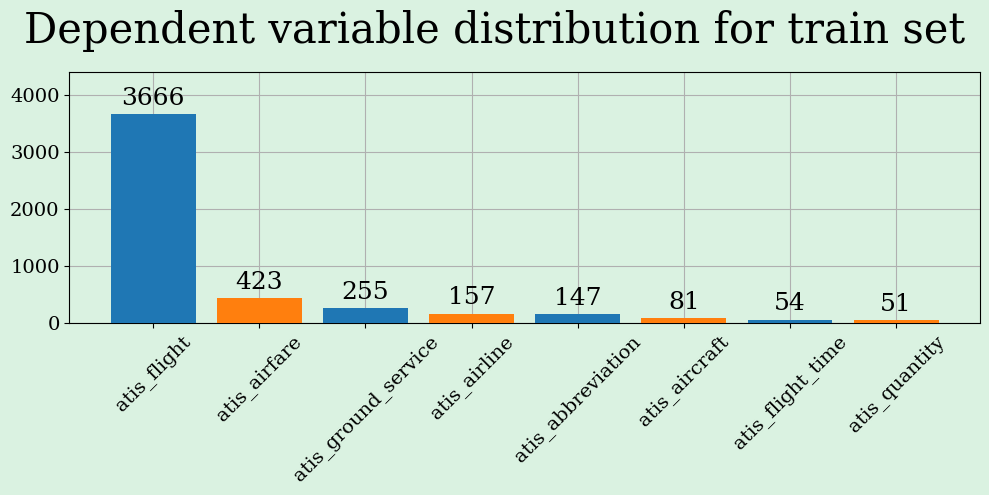

In [9]:
classes_distribution(train, 'Label', ' for train set')

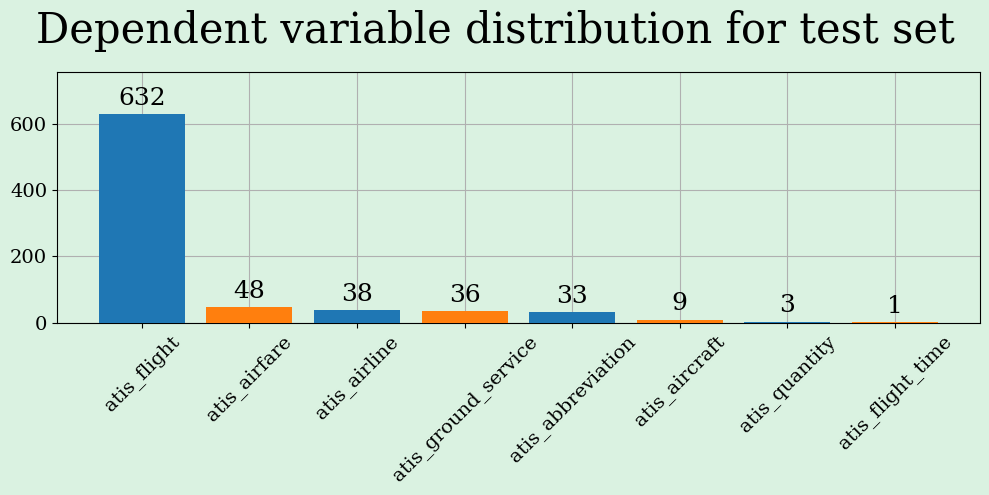

In [10]:
classes_distribution(test, 'Label', ' for test set')

### Are there any labels that are in the test set and not in the train set?

In [11]:
len(set(train['Label'].unique()) ^ set(test['Label'].unique()))

0

### Compare train and test distributions

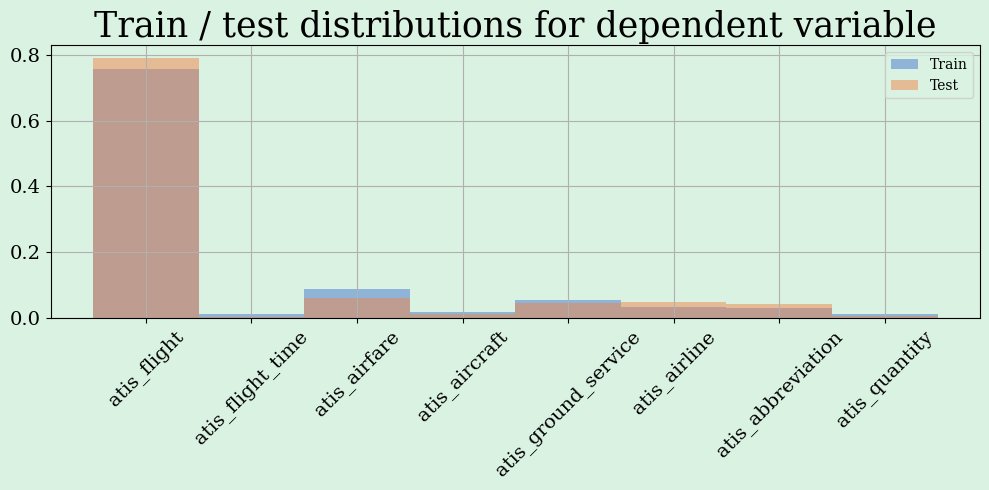

In [12]:
def train_test_distributions(y_train, y_test, text_labels=None):
    fig, ax = plt.subplots(figsize=(10,5))
    unique_labels = len(y_train.unique()) + 1
    ax.hist(y_train, label='Train', density=True, alpha=0.5,
            align='mid', bins=np.arange(unique_labels) - 0.5)
    ax.hist(y_test, label='Test', density=True, alpha=0.5,
            align='mid', bins=np.arange(unique_labels) - 0.5)
    if text_labels is None:
        text_labels = sorted(y_train.unique())
    ax.set_xticks(text_labels)
    ax.set_xticklabels(text_labels, rotation=45)
    ax.legend()
    plt.title('Train / test distributions for dependent variable')
    plt.tight_layout()
    plt.show()
train_test_distributions(train['Label'], test['Label'])

# <span style="color:#01872A; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 30px; "> Step 1 results:</span>

### 1. No missing data.
### 2. Imbalanced classes.
### 3. Train and test distributions are close to each other.

<div id="Step2">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; "> Step 2. Establish the baseline.</span>

### Establish a baseline with Logistic regression and CountVectorizer preprocessing

In [13]:
X_train, X_test = train[['Question']], test[['Question']]
y_train, y_test = train['Label'], test['Label']
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')

X_train shape: (4834, 1), y_train shape: (4834,)


In [14]:
def baseline_model(column):
    ct = ColumnTransformer(transformers=[
        ('Vectorizer', CountVectorizer(min_df=10), column)], sparse_threshold=0,
        remainder='drop')
    pipeline = Pipeline(steps=[
        ('Transformer', ct),
        ('Model', LogisticRegression(max_iter=200))
    ])
    return pipeline

def predict_baseline(X_train, y_train, X_test, y_test, column):
    pipeline = baseline_model(column)
    pipeline.fit(X_train, y_train)
    prediction = pipeline.predict(X_test)
    return prediction

In [15]:
y_pred = predict_baseline(X_train, y_train, X_test, y_test, 'Question')
baseline_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy score for baseline model: {baseline_accuracy}')

Accuracy score for baseline model: 0.9825


In [16]:
score_df = pd.DataFrame(columns=['ModelName', 'Score'])

In [17]:
def update_scores(score_df, model_name, score):
    model_dict = dict()
    model_dict['ModelName'] = model_name
    model_dict['Score'] = score
    if model_name not in score_df['ModelName'].values:
        score_df = score_df.append(model_dict, ignore_index=True)
    else:
        index = score_df[score_df['ModelName'] == model_name].index[0]
        score_df.at[index, 'Score'] = score
    return score_df
score_df = update_scores(score_df, 'Baseline', baseline_accuracy)

### Baseline error analysis

In [18]:
baseline_errors = X_test[y_test != y_pred].copy()
baseline_errors['Predicted'] = y_pred[baseline_errors.index]
baseline_errors['Actual'] = y_test[baseline_errors.index]
baseline_errors[:5]

,Question,Predicted,Actual
107,show me the connecting flights between boston and denver and the types of aircraft used,atis_aircraft,atis_flight
183,at the charlotte airport how many different types of aircraft are there for us air,atis_quantity,atis_aircraft
422,i need the fares on flights from washington to toronto on a saturday,atis_flight,atis_airfare
579,list type of aircraft for all flights from charlotte,atis_flight,atis_aircraft
581,list flights from orlando to tacoma on saturday of fare basis code of q,atis_airfare,atis_flight


### Types of errors

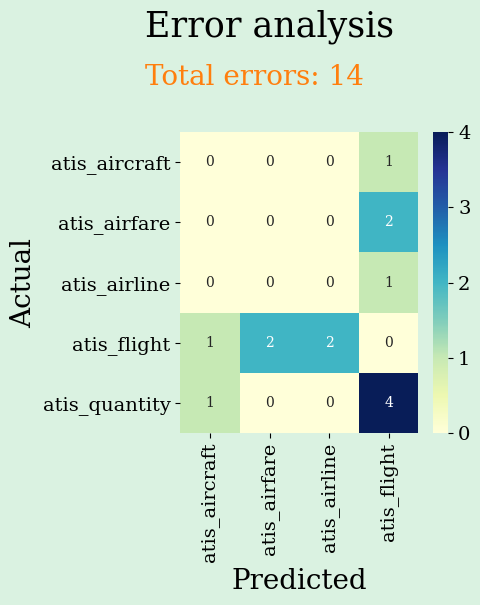

In [19]:
def error_type_heatmap(error_table):
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(error_table, annot=True, cmap='YlGnBu', ax=ax)
    ax.set_xlabel('Predicted', fontsize=20)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_yticklabels(error_table.index, rotation=0)
    fig.text(0.3, 1.2, 'Error analysis', size=25, va='top')
    fig.text(0.3, 1.05, f'Total errors: {error_table.sum().sum()} ',
             color=orange, size=20)
    plt.tight_layout()
    plt.show()

baseline_error_table = \
    baseline_errors.pivot_table(index='Predicted', columns='Actual',
                                aggfunc='count', values='Question',
                                fill_value=0)
error_type_heatmap(baseline_error_table)

In [20]:
print(f'Total errors: {len(baseline_errors)}')

Total errors: 14


# <span style="color:#01872A; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 30px; "> Step 2 results:</span>

### 1. Logistic regression (the baseline model) gives quite good result in classification.
### 2. Errors made by the baseline classificator are not obvious and may be hardto correct.

<div id="Step3">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; ">Step 3. Remove stopwords.</span>


In [21]:
def remove_stopwords(df, column_name):
    # english_stopwords = stopwords.words('english')
    english_stopwords = []
    english_stopwords += ['many']
    english_stopwords += ['how']
    df[column_name + 'Tokenized'] = \
        df[column_name].apply(nltk.tokenize.word_tokenize)
    df[column_name + 'NoStopwords'] = \
        df[column_name + 'Tokenized'].apply(lambda x:
                                            ' '.join([word for word in x if word
                                             not in english_stopwords]))
    return df

In [22]:
user_text_column = 'Question'
X_train = remove_stopwords(train, user_text_column)
X_train.head()

,Question,Label,QuestionTokenized,QuestionNoStopwords
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,atis_flight,"[i, want, to, fly, from, boston, at, 838, am, and, arrive, in, denver, at, 1110, in, the, morning]",i want to fly from boston at 838 am and arrive in denver at 1110 in the morning
1,what flights are available from pittsburgh to baltimore on thursday morning,atis_flight,"[what, flights, are, available, from, pittsburgh, to, baltimore, on, thursday, morning]",what flights are available from pittsburgh to baltimore on thursday morning
2,what is the arrival time in san francisco for the 755 am flight leaving washington,atis_flight_time,"[what, is, the, arrival, time, in, san, francisco, for, the, 755, am, flight, leaving, washington]",what is the arrival time in san francisco for the 755 am flight leaving washington
3,cheapest airfare from tacoma to orlando,atis_airfare,"[cheapest, airfare, from, tacoma, to, orlando]",cheapest airfare from tacoma to orlando
4,round trip fares from pittsburgh to philadelphia under 1000 dollars,atis_airfare,"[round, trip, fares, from, pittsburgh, to, philadelphia, under, 1000, dollars]",round trip fares from pittsburgh to philadelphia under 1000 dollars


In [23]:
X_test = remove_stopwords(test, user_text_column)

In [24]:
y_pred = predict_baseline(X_train, y_train, X_test, y_test,
                        'QuestionNoStopwords')
removed_stopwords_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy score for baseline model with removed stopwords: '
      f'{removed_stopwords_accuracy}')
score_df = update_scores(score_df, 'Baseline with\n removed\n stopwords',
                         removed_stopwords_accuracy)

Accuracy score for baseline model with removed stopwords: 0.98375


In [25]:
stopwords_errors = X_test[y_test != y_pred].copy()
stopwords_errors['Predicted'] = y_pred[stopwords_errors.index]
stopwords_errors['Actual'] = y_test[stopwords_errors.index]
stopwords_errors.head()

,Question,Label,QuestionTokenized,QuestionNoStopwords,Predicted,Actual
107,show me the connecting flights between boston and denver and the types of aircraft used,atis_flight,"[show, me, the, connecting, flights, between, boston, and, denver, and, the, types, of, aircraft, used]",show me the connecting flights between boston and denver and the types of aircraft used,atis_aircraft,atis_flight
154,how many canadian airlines international flights use j31,atis_quantity,"[how, many, canadian, airlines, international, flights, use, j31]",canadian airlines international flights use j31,atis_flight,atis_quantity
155,how many canadian airlines international flights use aircraft 320,atis_quantity,"[how, many, canadian, airlines, international, flights, use, aircraft, 320]",canadian airlines international flights use aircraft 320,atis_flight,atis_quantity
156,how many canadian airlines flights use aircraft dh8,atis_quantity,"[how, many, canadian, airlines, flights, use, aircraft, dh8]",canadian airlines flights use aircraft dh8,atis_flight,atis_quantity
422,i need the fares on flights from washington to toronto on a saturday,atis_airfare,"[i, need, the, fares, on, flights, from, washington, to, toronto, on, a, saturday]",i need the fares on flights from washington to toronto on a saturday,atis_flight,atis_airfare


# <span style="color:#01872A; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 30px; "> Step 3 results:</span>

### 1. Removing stopwords gives slight accuracy improvement.

<div id="Step4">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px; ">Step 4. Replace airline names.</span>
Replace airline names with AirlineName placeholder

In [26]:
airline_names = [
    'alaska', 'delta', 'american', 'united', 'northwest',
    'continental', 'canadian', 'eastern', 'lufthansa' ]

In [27]:
airline_names_full = [airline_name + ' airlines' for airline_name in
                    airline_names]
airline_names_full = '|'.join(airline_names_full)
airline_names_full += '|'.join(airline_names)
airline_names_full

'alaska airlines|delta airlines|american airlines|united airlines|northwest airlines|continental airlines|canadian airlines|eastern airlines|lufthansa airlinesalaska|delta|american|united|northwest|continental|canadian|eastern|lufthansa'

In [28]:
airline_placeholder = 'AirlineName'
X_train['QuestionAirlines'] = \
    X_train['QuestionNoStopwords'].str.replace(airline_names_full,
                                    airline_placeholder, regex=True)
X_test['QuestionAirlines'] = \
    X_test['QuestionNoStopwords'].str.replace(airline_names_full,
                                    airline_placeholder, regex=True)
user_text_column = 'QuestionAirlines'
y_pred = predict_baseline(X_train, y_train, X_test, y_test,
                        user_text_column)
accuracy_score(y_test, y_pred)
print(f'Accuracy score for baseline model with removed airline names: '
      f'{removed_stopwords_accuracy}')
score_df = update_scores(score_df, 'Baseline with\n removed\n airline\n names',
                         removed_stopwords_accuracy)

Accuracy score for baseline model with removed airline names: 0.98375


In [29]:
airline_placeholder_errors = X_test[y_test != y_pred].copy()
airline_placeholder_errors['Predicted'] = y_pred[airline_placeholder_errors.index]
airline_placeholder_errors['Actual'] = y_test[airline_placeholder_errors.index]
airline_placeholder_errors.head()

,Question,Label,QuestionTokenized,QuestionNoStopwords,QuestionAirlines,Predicted,Actual
107,show me the connecting flights between boston and denver and the types of aircraft used,atis_flight,"[show, me, the, connecting, flights, between, boston, and, denver, and, the, types, of, aircraft, used]",show me the connecting flights between boston and denver and the types of aircraft used,show me the connecting flights between boston and denver and the types of aircraft used,atis_aircraft,atis_flight
154,how many canadian airlines international flights use j31,atis_quantity,"[how, many, canadian, airlines, international, flights, use, j31]",canadian airlines international flights use j31,AirlineName international flights use j31,atis_flight,atis_quantity
155,how many canadian airlines international flights use aircraft 320,atis_quantity,"[how, many, canadian, airlines, international, flights, use, aircraft, 320]",canadian airlines international flights use aircraft 320,AirlineName international flights use aircraft 320,atis_flight,atis_quantity
156,how many canadian airlines flights use aircraft dh8,atis_quantity,"[how, many, canadian, airlines, flights, use, aircraft, dh8]",canadian airlines flights use aircraft dh8,AirlineName flights use aircraft dh8,atis_flight,atis_quantity
183,at the charlotte airport how many different types of aircraft are there for us air,atis_aircraft,"[at, the, charlotte, airport, how, many, different, types, of, aircraft, are, there, for, us, air]",at the charlotte airport different types of aircraft are there for us air,at the charlotte airport different types of aircraft are there for us air,atis_quantity,atis_aircraft


# <span style="color:#01872A; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 30px; "> Step 4 results:</span>

### 1. Replacing airline names gives slight accuracy improvement.

<div id="Step5">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;">Step 5. Normalize user text.</span>


In [30]:
X_train['Spacy'] = X_train['QuestionAirlines'].apply(nlp)
X_test['Spacy'] = X_test['QuestionAirlines'].apply(nlp)
X_train.head()

,Question,Label,QuestionTokenized,QuestionNoStopwords,QuestionAirlines,Spacy
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,atis_flight,"[i, want, to, fly, from, boston, at, 838, am, and, arrive, in, denver, at, 1110, in, the, morning]",i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,"(i, want, to, fly, from, boston, at, 838, am, and, arrive, in, denver, at, 1110, in, the, morning)"
1,what flights are available from pittsburgh to baltimore on thursday morning,atis_flight,"[what, flights, are, available, from, pittsburgh, to, baltimore, on, thursday, morning]",what flights are available from pittsburgh to baltimore on thursday morning,what flights are available from pittsburgh to baltimore on thursday morning,"(what, flights, are, available, from, pittsburgh, to, baltimore, on, thursday, morning)"
2,what is the arrival time in san francisco for the 755 am flight leaving washington,atis_flight_time,"[what, is, the, arrival, time, in, san, francisco, for, the, 755, am, flight, leaving, washington]",what is the arrival time in san francisco for the 755 am flight leaving washington,what is the arrival time in san francisco for the 755 am flight leaving washington,"(what, is, the, arrival, time, in, san, francisco, for, the, 755, am, flight, leaving, washington)"
3,cheapest airfare from tacoma to orlando,atis_airfare,"[cheapest, airfare, from, tacoma, to, orlando]",cheapest airfare from tacoma to orlando,cheapest airfare from tacoma to orlando,"(cheapest, airfare, from, tacoma, to, orlando)"
4,round trip fares from pittsburgh to philadelphia under 1000 dollars,atis_airfare,"[round, trip, fares, from, pittsburgh, to, philadelphia, under, 1000, dollars]",round trip fares from pittsburgh to philadelphia under 1000 dollars,round trip fares from pittsburgh to philadelphia under 1000 dollars,"(round, trip, fares, from, pittsburgh, to, philadelphia, under, 1000, dollars)"


In [31]:
def replace_named_entities(x, entity_dict):
    string = x.text
    for ent in x.ents:
        if ent.label_ in entity_dict.keys():
            placeholder = entity_dict[ent.label_]
            string = string.replace(ent.text, placeholder)
    return string
entity_dict = {'GPE': 'CityName', 'MONEY': 'Money', 'DATE': 'Date',
               'TIME': 'Time'}
X_train['NamedEntityNormalized'] = \
    X_train['Spacy'].apply(replace_named_entities, args=(entity_dict,))
X_test['NamedEntityNormalized'] = \
    X_test['Spacy'].apply(replace_named_entities, args=(entity_dict,))

In [32]:
user_text_column = 'NamedEntityNormalized'
y_pred = predict_baseline(X_train, y_train, X_test, y_test,
                          user_text_column)
normalized_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy score for baseline model with normalized text: '
      f'{normalized_accuracy}')
score_df = update_scores(score_df, 'Baseline with\n normalized\n text',
                         normalized_accuracy)

Accuracy score for baseline model with normalized text: 0.985


In [33]:
normalized_errors = X_test[y_test != y_pred].copy()
normalized_errors['Predicted'] = y_pred[normalized_errors.index]
normalized_errors['Actual'] = y_test[normalized_errors.index]
normalized_errors.head()

,Question,Label,QuestionTokenized,QuestionNoStopwords,QuestionAirlines,Spacy,NamedEntityNormalized,Predicted,Actual
107,show me the connecting flights between boston and denver and the types of aircraft used,atis_flight,"[show, me, the, connecting, flights, between, boston, and, denver, and, the, types, of, aircraft, used]",show me the connecting flights between boston and denver and the types of aircraft used,show me the connecting flights between boston and denver and the types of aircraft used,"(show, me, the, connecting, flights, between, boston, and, denver, and, the, types, of, aircraft, used)",show me the connecting flights between CityName and CityName and the types of aircraft used,atis_aircraft,atis_flight
154,how many canadian airlines international flights use j31,atis_quantity,"[how, many, canadian, airlines, international, flights, use, j31]",canadian airlines international flights use j31,AirlineName international flights use j31,"(AirlineName, international, flights, use, j31)",AirlineName international flights use j31,atis_flight,atis_quantity
155,how many canadian airlines international flights use aircraft 320,atis_quantity,"[how, many, canadian, airlines, international, flights, use, aircraft, 320]",canadian airlines international flights use aircraft 320,AirlineName international flights use aircraft 320,"(AirlineName, international, flights, use, aircraft, 320)",AirlineName international flights use aircraft 320,atis_flight,atis_quantity
156,how many canadian airlines flights use aircraft dh8,atis_quantity,"[how, many, canadian, airlines, flights, use, aircraft, dh8]",canadian airlines flights use aircraft dh8,AirlineName flights use aircraft dh8,"(AirlineName, flights, use, aircraft, dh8)",AirlineName flights use aircraft dh8,atis_flight,atis_quantity
183,at the charlotte airport how many different types of aircraft are there for us air,atis_aircraft,"[at, the, charlotte, airport, how, many, different, types, of, aircraft, are, there, for, us, air]",at the charlotte airport different types of aircraft are there for us air,at the charlotte airport different types of aircraft are there for us air,"(at, the, charlotte, airport, different, types, of, aircraft, are, there, for, us, air)",at the CityName airport different types of aircraft are there for us air,atis_quantity,atis_aircraft


In [34]:
print(f'Total errors: {len(normalized_errors)}')

Total errors: 12


# <span style="color:#01872A; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 30px; "> Step 5 results:</span>

### 1. Results of normalization - small score improvement.

<div id="Step6">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;">Step 6. Neural networks.</span>

### Use neural networks to improve score.

## Preprocess data for Neural Networks

In [35]:
tokenizer = Tokenizer(oov_token='oov')
tokenizer.fit_on_texts(train[user_text_column])
train_sequences = tokenizer.texts_to_sequences(train[user_text_column])
test_sequences = tokenizer.texts_to_sequences(test[user_text_column])

In [36]:
total_words = len(tokenizer.word_index)
print(f'Total different words: {total_words}')

Total different words: 724


In [37]:
max_seq_len = max([len(seq) for seq in train_sequences])
print(f'Max sequence length: {max_seq_len}')

Max sequence length: 41


## Make all sequences have the same length

In [38]:
X_train_tf = pad_sequences(train_sequences,maxlen=max_seq_len, padding='post')
X_test_tf = pad_sequences(test_sequences, maxlen=max_seq_len, padding='post')
print(f'X_train_tf shape: {X_train_tf.shape}, '
      f'X_test_tf shape: {X_test_tf.shape}')

X_train_tf shape: (4834, 41), X_test_tf shape: (800, 41)


## Preprocess labels for Neural Networks

In [39]:
label_encoder = LabelEncoder()
tr_labels_encoded = label_encoder.fit_transform(train['Label'])
test_labels_encoded = label_encoder.transform(test['Label'])

In [40]:
y_train_tf = to_categorical(tr_labels_encoded)
y_test_tf = to_categorical(test_labels_encoded)
print(f'y_train_tf shape: {y_train_tf.shape}, '
      f'y_test_tf shape: {y_test_tf.shape}')

y_train_tf shape: (4834, 8), y_test_tf shape: (800, 8)


## Simple tensorflow model with one LSTM layer

In [41]:
model = Sequential()
model.add(Embedding(input_dim=total_words + 1, output_dim=200,
                    input_length=max_seq_len))
model.add(LSTM(40))
# model.add(Dense(40, activation='relu'))
model.add(Dense(8, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
# model.summary()
model.fit(X_train_tf, y_train_tf, epochs=30, batch_size=32,
          validation_data=(X_test_tf, y_test_tf))
lstm_nn_score = model.evaluate(X_test_tf, y_test_tf)[1]
print(f'Accuracy score for LSTM NN model: {lstm_nn_score}')
score_df = update_scores(score_df, 'Simple NN\n model', lstm_nn_score)

Epoch 1/30
152/152 [==============================] - 5s 20ms/step - loss: 1.0507 - accuracy: 0.7526 - val_loss: 0.8722 - val_accuracy: 0.7900

In [42]:
def create_model(optimizer='adam',
                 kernel_initializer='glorot_uniform',
                 dropout=0.2):
    model = Sequential()
    model.add(Embedding(input_dim=total_words + 1, output_dim=200,
                        input_length=max_seq_len))
    model.add(LSTM(50, return_sequences=True))
    model.add(TimeDistributed(Dense(70, activation='relu')))
    model.add(Flatten())
    model.add(Dense(40, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
model = create_model()
model.fit(X_train_tf, y_train_tf, epochs=30, batch_size=32,
          validation_data=(X_test_tf, y_test_tf))
complex_nn_score = model.evaluate(X_test_tf, y_test_tf)[1]

Epoch 1/30
152/152 [==============================] - 6s 22ms/step - loss: 0.6763 - accuracy: 0.8151 - val_loss: 0.2538 - val_accuracy: 0.9187

In [43]:
print(f'Accuracy score for complex NN model: {complex_nn_score}')
score_df = update_scores(score_df, 'Complex NN\n model', complex_nn_score)
score_df

Accuracy score for complex NN model: 0.9925000071525574


,ModelName,Score
0,Baseline,0.98250
1,Baseline with\n removed\n stopwords,0.98375
2,Baseline with\n removed\n airline\n names,0.98375
3,Baseline with\n normalized\n text,0.98500
4,Simple NN\n model,0.81125
5,Complex NN\n model,0.99250


# <span style="color:#01872A; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 30px; "> Step 6 results:</span>

### 1. Results of using neural networks - slight accuracy score improvement.

<div id="Step7">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;">Step 7. Error analysis for NN model.</span>

In [44]:
nn_prediction = np.argmax(model.predict(X_test_tf), axis=1)
nn_prediction = label_encoder.inverse_transform(nn_prediction)

### Error analysis

In [45]:
nn_errors = X_test[y_test != nn_prediction].copy()
nn_errors['Predicted'] = nn_prediction[nn_errors.index]
nn_errors['Actual'] = y_test[nn_errors.index]
nn_errors.head()

,Question,Label,QuestionTokenized,QuestionNoStopwords,QuestionAirlines,Spacy,NamedEntityNormalized,Predicted,Actual
582,list airfares for first class round trip from detroit to st. petersburg,atis_airfare,"[list, airfares, for, first, class, round, trip, from, detroit, to, st., petersburg]",list airfares for first class round trip from detroit to st. petersburg,list airfares for first class round trip from detroit to st. petersburg,"(list, airfares, for, first, class, round, trip, from, detroit, to, st, ., petersburg)",list airfares for first class round trip from CityName to CityName CityName,atis_flight,atis_airfare
652,how many northwest flights leave st. paul,atis_flight,"[how, many, northwest, flights, leave, st., paul]",northwest flights leave st. paul,AirlineName flights leave st. paul,"(AirlineName, flights, leave, st, ., paul)",AirlineName flights leave st. paul,atis_quantity,atis_flight
653,how many northwest flights leave washington dc,atis_flight,"[how, many, northwest, flights, leave, washington, dc]",northwest flights leave washington dc,AirlineName flights leave washington dc,"(AirlineName, flights, leave, washington, dc)",AirlineName flights leave CityName,atis_quantity,atis_flight
654,how many flights does northwest have leaving dulles,atis_flight,"[how, many, flights, does, northwest, have, leaving, dulles]",flights does northwest have leaving dulles,flights does AirlineName have leaving dulles,"(flights, does, AirlineName, have, leaving, dulles)",flights does AirlineName have leaving CityName,atis_quantity,atis_flight
696,list all flights on all types of aircraft arriving in denver between 8 and 9 pm,atis_flight,"[list, all, flights, on, all, types, of, aircraft, arriving, in, denver, between, 8, and, 9, pm]",list all flights on all types of aircraft arriving in denver between 8 and 9 pm,list all flights on all types of aircraft arriving in denver between 8 and 9 pm,"(list, all, flights, on, all, types, of, aircraft, arriving, in, denver, between, 8, and, 9, pm)",list all flights on all types of aircraft arriving in CityName Date,atis_aircraft,atis_flight


In [46]:
print(f'Total errors: {len(nn_errors)}')

Total errors: 6


### Mistakes both in baseline errors and NN errors

In [47]:
X_test.loc[set(nn_errors.index) & set(baseline_errors.index)]

,Question,Label,QuestionTokenized,QuestionNoStopwords,QuestionAirlines,Spacy,NamedEntityNormalized
710,how many flights does alaska airlines have to burbank,atis_flight,"[how, many, flights, does, alaska, airlines, have, to, burbank]",flights does alaska airlines have to burbank,flights does AirlineName have to burbank,"(flights, does, AirlineName, have, to, burbank)",flights does AirlineName have to CityName
582,list airfares for first class round trip from detroit to st. petersburg,atis_airfare,"[list, airfares, for, first, class, round, trip, from, detroit, to, st., petersburg]",list airfares for first class round trip from detroit to st. petersburg,list airfares for first class round trip from detroit to st. petersburg,"(list, airfares, for, first, class, round, trip, from, detroit, to, st, ., petersburg)",list airfares for first class round trip from CityName to CityName CityName
652,how many northwest flights leave st. paul,atis_flight,"[how, many, northwest, flights, leave, st., paul]",northwest flights leave st. paul,AirlineName flights leave st. paul,"(AirlineName, flights, leave, st, ., paul)",AirlineName flights leave st. paul
653,how many northwest flights leave washington dc,atis_flight,"[how, many, northwest, flights, leave, washington, dc]",northwest flights leave washington dc,AirlineName flights leave washington dc,"(AirlineName, flights, leave, washington, dc)",AirlineName flights leave CityName
654,how many flights does northwest have leaving dulles,atis_flight,"[how, many, flights, does, northwest, have, leaving, dulles]",flights does northwest have leaving dulles,flights does AirlineName have leaving dulles,"(flights, does, AirlineName, have, leaving, dulles)",flights does AirlineName have leaving CityName


### Mistakes in NN errors what were correctly classified by baseline errors

In [48]:
only_nn_erorrs = \
    X_test.loc[set(nn_errors.index).difference(set(baseline_errors.index))]
only_nn_erorrs['Predicted'] = nn_prediction[only_nn_erorrs.index]
only_nn_erorrs

,Question,Label,QuestionTokenized,QuestionNoStopwords,QuestionAirlines,Spacy,NamedEntityNormalized,Predicted
696,list all flights on all types of aircraft arriving in denver between 8 and 9 pm,atis_flight,"[list, all, flights, on, all, types, of, aircraft, arriving, in, denver, between, 8, and, 9, pm]",list all flights on all types of aircraft arriving in denver between 8 and 9 pm,list all flights on all types of aircraft arriving in denver between 8 and 9 pm,"(list, all, flights, on, all, types, of, aircraft, arriving, in, denver, between, 8, and, 9, pm)",list all flights on all types of aircraft arriving in CityName Date,atis_aircraft


### Types of errors

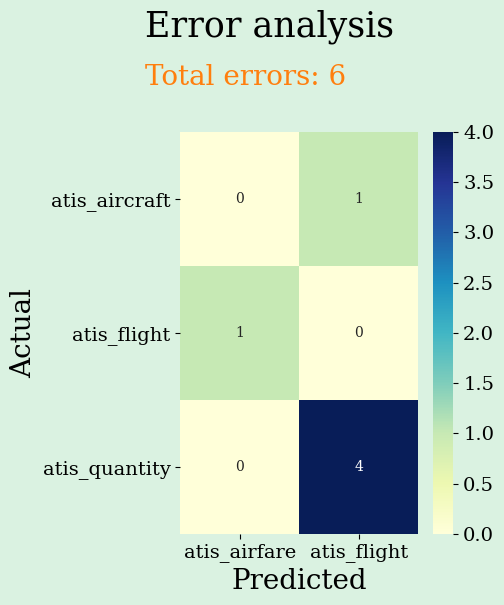

In [49]:
nn_errors_table = \
    nn_errors.pivot_table(index='Predicted', columns='Actual', aggfunc='count',
                          values='Label', fill_value=0)
# nn_errors_table
error_type_heatmap(nn_errors_table)


In [50]:
print(f'Total NN errors: {len(nn_errors)}')

Total NN errors: 6


In [51]:
print(f'Total baseline errors: {len(baseline_errors)}')

Total baseline errors: 14


# <span style="color:#01872A; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 30px; "> Step 7 results:</span>

### 1. Looks like there is no space for improvement - questions that were incorectly classified by Neural network seem to be connected with 2 different intents.

<div id="Step8">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;">Step 8. Metrics analysis.</span>

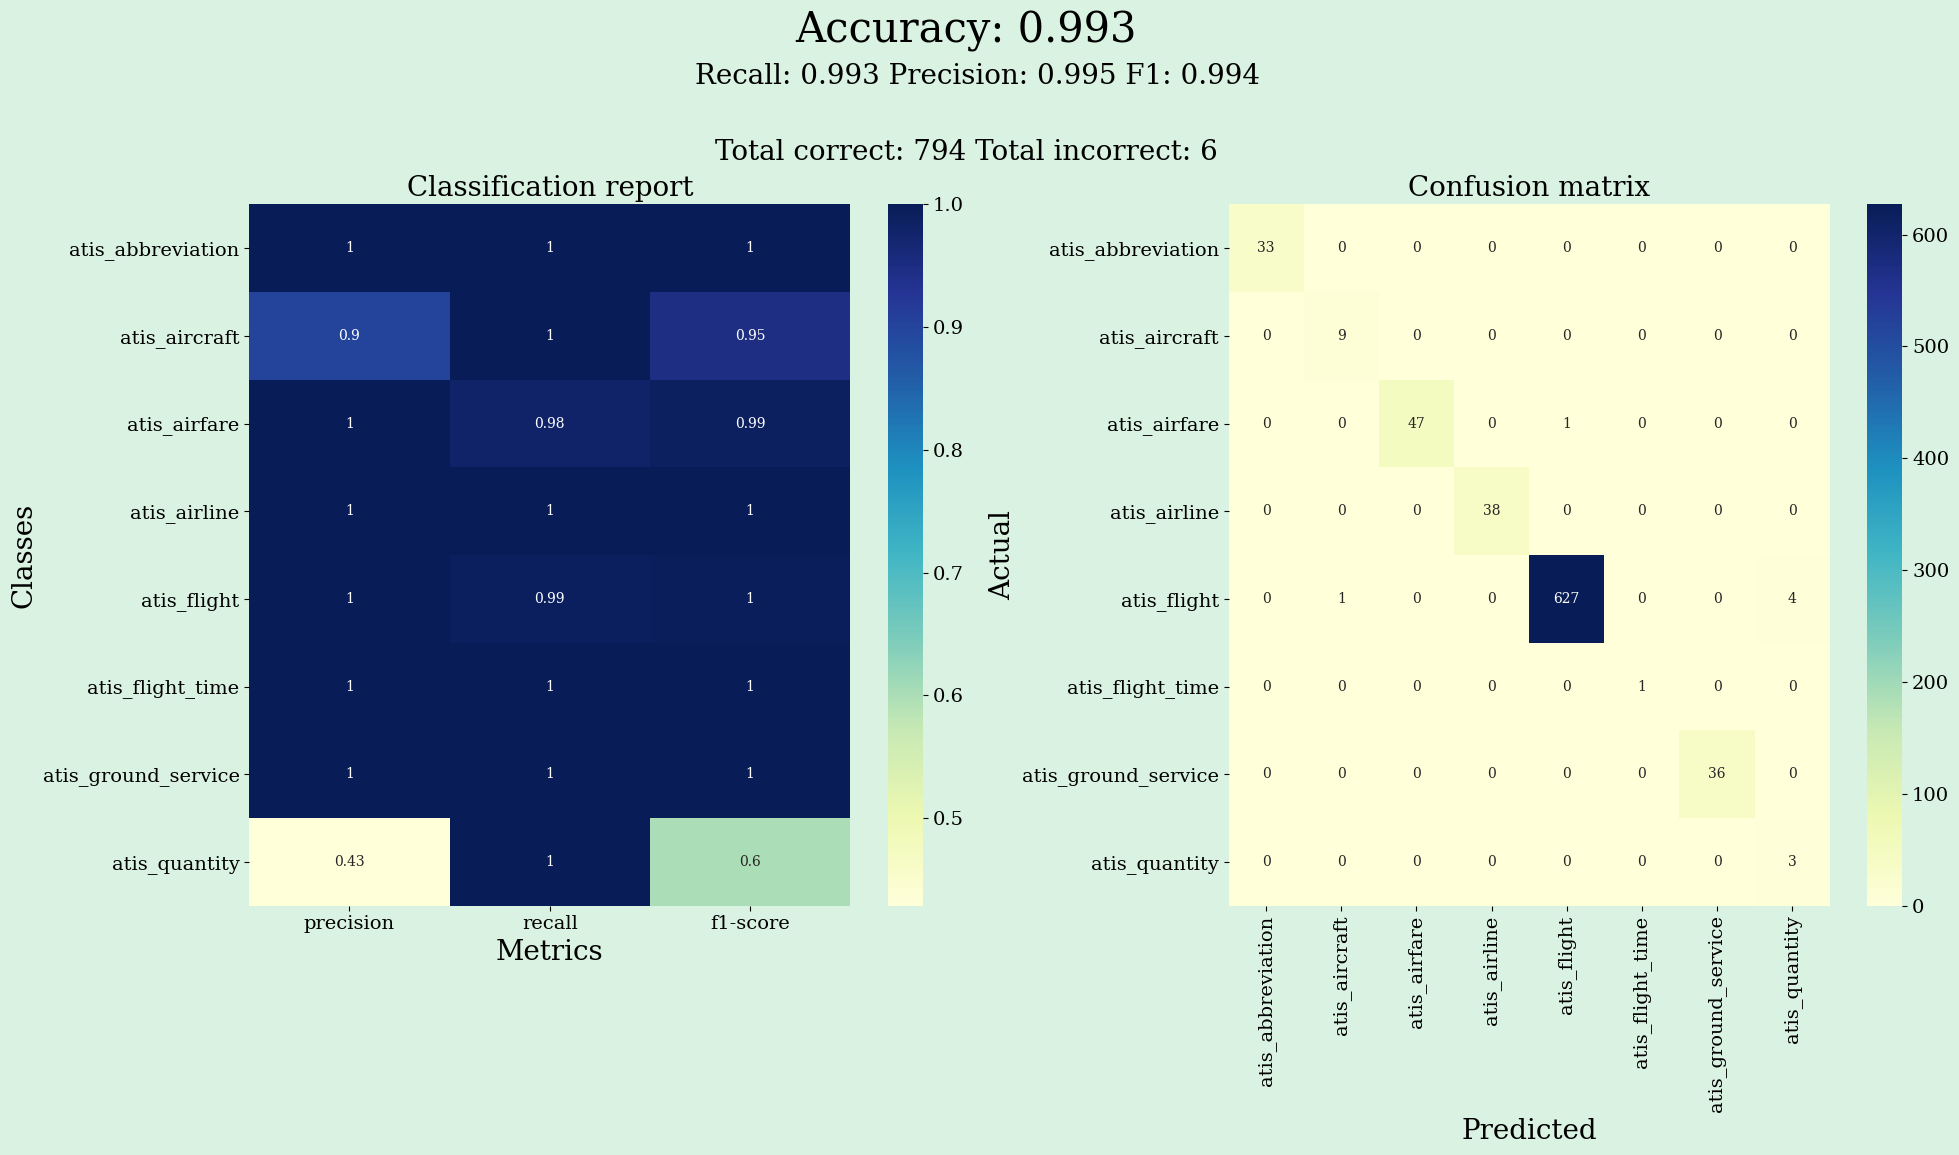

In [52]:
def results(y_test, y_hat, average=None):
    from sklearn.metrics import confusion_matrix, classification_report, \
        accuracy_score, recall_score, precision_score, f1_score

    unique_y = sorted(y_test.unique())
    if average is None:
        if len(unique_y) == 2:
            average = 'binary'
        else:
            average = 'weighted'
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Overall metrics
    fig.text(0.4, 1.15, f'Accuracy: {accuracy_score(y_test, y_hat):.3f} ',
                 va='top', size=30)
    fig.text(0.35, 1.07,
                f'Recall: {recall_score(y_test, y_hat, average=average):.3f} '
                f'Precision: {precision_score(y_test, y_hat, average=average):.3f} '
                f'F1: {f1_score(y_test, y_hat, average=average):.3f} ', va='bottom',
                size=20)
    value_counts = (y_test == y_hat).value_counts()
    fig.text(0.36, 1.0, f'Total correct: {value_counts[True]} Total incorrect:'
                       f' {value_counts[False]}', fontsize=20)

    # Classification report
    cr = classification_report(y_test, y_hat, output_dict=True)
    sns.heatmap(pd.DataFrame(cr).iloc[:-1, :-3].T, annot=True, ax=axes[0],
                cmap='YlGnBu')
    axes[0].set_xlabel('Metrics', fontsize=20)
    axes[0].set_ylabel('Classes', fontsize=20)
    axes[0].set_title('Classification report', fontsize=20)

    # Confusion matrix
    cm = pd.DataFrame(confusion_matrix(y_test, y_hat), columns=unique_y,
                      index=unique_y)
    sns.heatmap(cm, annot=True, ax=axes[1], cmap='YlGnBu', fmt='.0f')
    axes[1].set_xlabel('Predicted', fontsize=20)
    axes[1].set_ylabel('Actual', fontsize=20)
    axes[1].set_title('Confusion matrix', fontsize=20)
    plt.tight_layout()
    plt.show();

results(y_test, nn_prediction)

### Learning curve

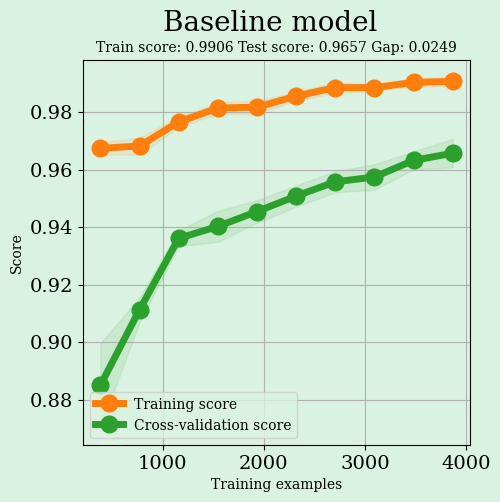

In [53]:
def plot_learning_curve(estimator, title, X, y, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 10), ylim=None):
    """
    Sourse:https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
    """
    from sklearn.model_selection import learning_curve
    fig, ax = plt.subplots(figsize=(5, 5))
    if ylim is not None:
        ax.set_ylim(*ylim)

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=-1,
                       train_sizes=train_sizes,
                       return_times=True, random_state=0)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    # ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color=orange)
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color=green)
    ax.plot(train_sizes, train_scores_mean, 'o-', color=orange,
                 label="Training score",  markersize=12)
    ax.plot(train_sizes, test_scores_mean, 'o-', color=green,
                 label="Cross-validation score",  markersize=12)
    ax.legend(loc="best")
    plt.suptitle(title, size=20)
    mean_train_score = train_scores[-1].mean().round(4)
    mean_test_score = test_scores[-1].mean().round(4)
    gap = mean_train_score - mean_test_score
    ax.set_title(f'Train score: {mean_train_score} '
                 f'Test score: {mean_test_score} '
                 f'Gap: {gap.round(4)}', size=10)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    plt.show()
plot_learning_curve(baseline_model('Question'),
                    'Baseline model', X_train[['Question']], y_train)

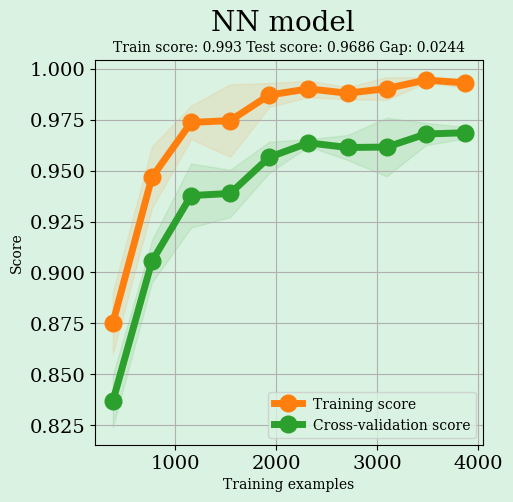

In [54]:
clf = KerasClassifier(build_fn=create_model, verbose=0, epochs=10)
plot_learning_curve(clf, 'NN model', X_train_tf, y_train_tf)

# <span style="color:#01872A; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 30px; "> Step 8 results:</span>

### 1. Precision, Recall and F1 seem to be quite good together with accuracy.

<div id="Step9">
</div>

# <span style="color:#01872A; display: block; padding:10px; background:#daf2e1;border-radius:20px; text-align: center; font-size: 40px;">Step 9. Conclusion.</span>


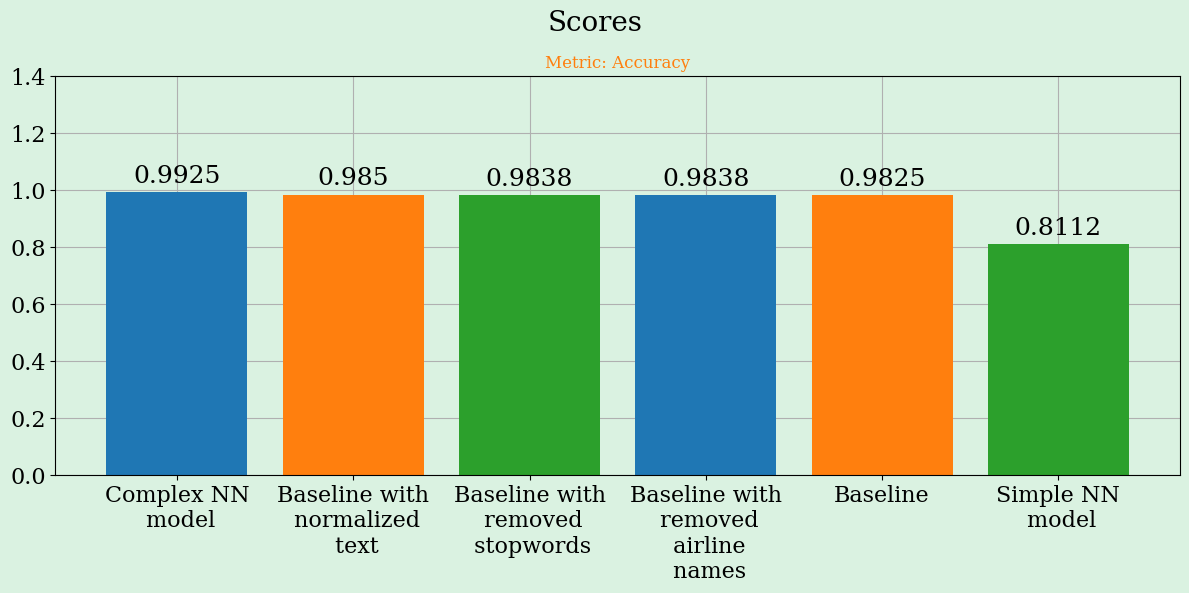

In [55]:
def plot_model_results(score_df, metric=''):
    fig, ax = plt.subplots(figsize=(12, 6))
    score_df.sort_values(['Score'], inplace=True, ascending=False)
    rects = ax.bar(x=score_df['ModelName'], height=score_df['Score'],
                   zorder=2, color=[blue, orange, green])
    autolabel(rects, ax, decimals=4)
    plt.suptitle('Scores', size=20)
    if metric:
        ax.set_title(f'Metric: {metric}', color=orange, size=12)
    ax.set_ylim(0.0, 1.40)
    ax.tick_params(axis='both', which='major', labelsize=16)
    # plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
    plt.tight_layout()
    plt.show();
plot_model_results(score_df, 'Accuracy')

### 1. Classifier results are pretty good (about 99% on the test set).
### 2. Even the baseline model (Logistic regression) gives good results.
### 3. Complex Neural Network gives only a small improvement on accuracy.